In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp
from pennylane.math import reduce_statevector


import time
import warnings
warnings.filterwarnings("ignore")

## Generating Bars and Stripes dataset

In [2]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 2
size = n**2
data = get_bars_and_stripes(n)



Sample bitstring: 1010


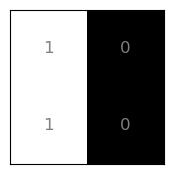

In [3]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

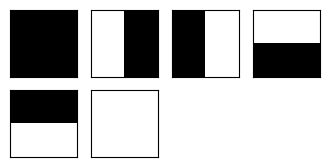

In [4]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

In [5]:
data

array([[0, 0, 0, 0],
       [1, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 1, 0, 0],
       [0, 0, 1, 1],
       [1, 1, 1, 1]])

## Getting Wavefunction of Dataset

In [6]:
n_qubits = 2
n_ancillas = 3
total_qubits = n_qubits + n_ancillas

In [7]:
data = torch.tensor(data,dtype=torch.float32)

for d in data:
    eps = 1e-6
    if torch.linalg.norm(d) < 1e-8:
        d = torch.full_like(d,eps)

    d = d/torch.linalg.norm(d)

In [8]:
dm = torch.einsum("bi,bj -> bij",data,data)
target_dm = dm.mean(dim=0)
target_dm = target_dm / torch.linalg.norm(target_dm)

In [9]:
def encode_conditional_state_with_ancilla_last(data):

    psi_full = torch.zeros(2**total_qubits, dtype=torch.complex64)

    for i in range(2**n_qubits):
        base_index = i * 8  # because 2^3 = 8 ancilla states
        psi_full[base_index + 0] = data[0][i]  # |00⟩ ancilla
        psi_full[base_index + 1] = data[1][i]  # |01⟩ ancilla
        psi_full[base_index + 2] = data[2][i]
        psi_full[base_index + 3] = data[3][i]
        psi_full[base_index + 4] = data[4][i]
        psi_full[base_index + 5] = data[5][i]

    return psi_full / torch.linalg.norm(psi_full)

data_full = encode_conditional_state_with_ancilla_last(data)

In [10]:
######## Verification of Encoding
# target_full_dm = torch.einsum("i,j -> ij",data_full,data_full)
# reduced_dm = reduce_statevector(data_full,range(n_qubits))
# reduced_dm /= torch.linalg.norm(reduced_dm)
target_full_dm = qml.math.dm_from_state_vector(data_full)

## Functions

In [11]:
def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance2_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance2 = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance2.real



def qcbm(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    full_psi = circuit_fn(params)
    px = reduce_statevector(full_psi, indices=range(num_qubits))
    loss = trdistance2_loss(px, py)
    return loss


In [12]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,interface="torch")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    for i in range(total_qubits):

        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


In [13]:
def fidelity_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    """
    Computes the fidelity loss between two quantum states.
    """
    px_dm = qml.math.dm_from_state_vector(px)

    return -1*qml.math.fidelity(px_dm,py) 

def vqc(circuit_fn,  params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):
    """
    Variational Quantum Circuit (VQC) function to compute the loss.
    """
    full_psi = circuit_fn(params)
    fid_loss = fidelity_loss(full_psi, py)
    return fid_loss.real

## Training the Model

In [14]:
initial_params = torch.rand((folds, 3 * total_qubits), requires_grad=True, dtype=torch.float32)

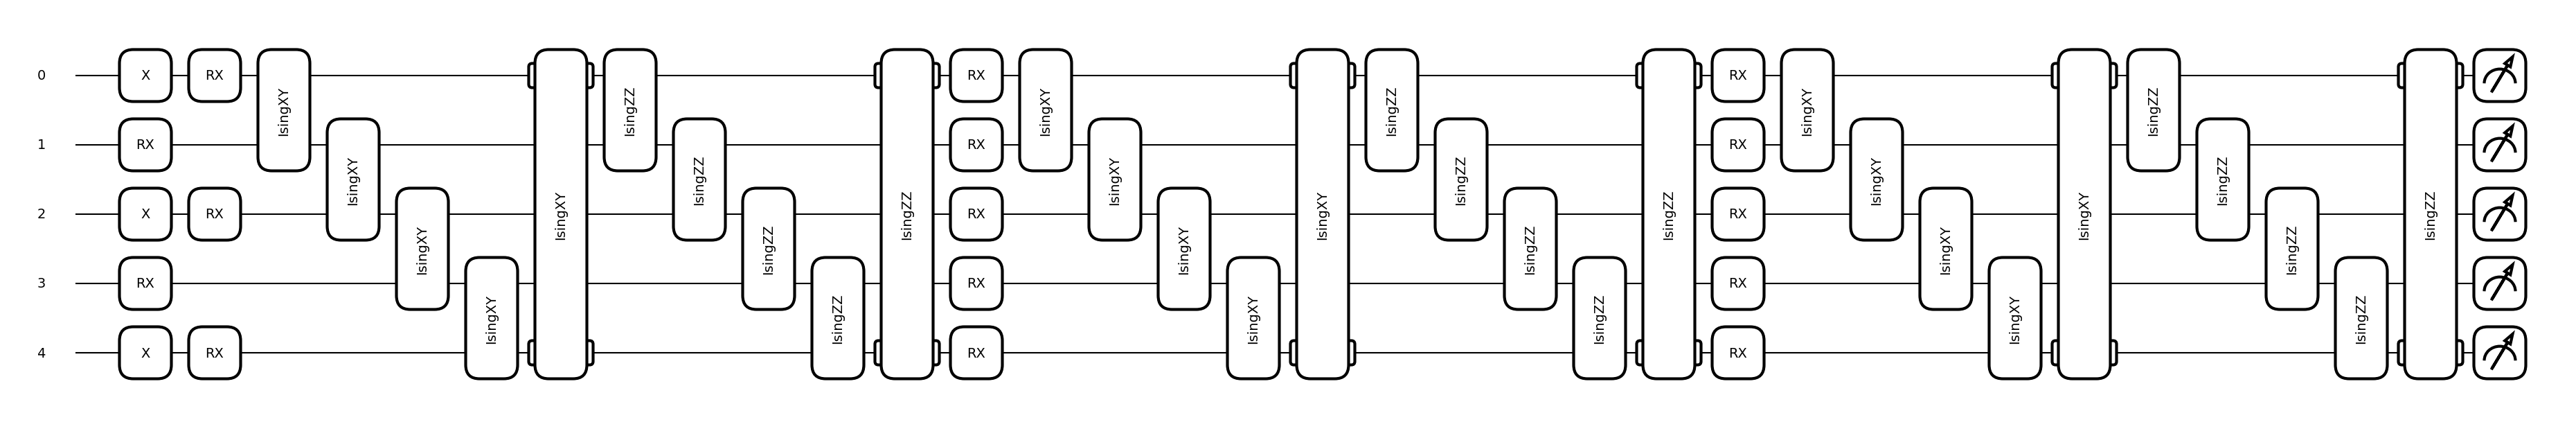

In [15]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [16]:
weights = initial_params
lr = 0.01
opt = torch.optim.Adam([weights], lr=lr)


loss_history = []
min_loss = qcbm(circuit, weights, target_dm)
optimal_params = torch.zeros((folds, 3* total_qubits), dtype=torch.float32)
n_epochs = 2000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss = qcbm(circuit, weights, target_dm)
    loss.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss} Time taken per iter: {end_time-start_time}")
    loss_history.append(loss.item())

    if loss < min_loss:
        min_loss = loss
        optimal_params = weights.detach().clone()


Step: 10 Loss: 0.2276141758267426 Time taken per iter: 0.006043910980224609
Step: 20 Loss: 0.11975168049869896 Time taken per iter: 0.006329774856567383
Step: 30 Loss: 0.060624934579211795 Time taken per iter: 0.0061070919036865234
Step: 40 Loss: 0.04147872701581986 Time taken per iter: 0.006303071975708008
Step: 50 Loss: 0.03693156559786019 Time taken per iter: 0.006206989288330078
Step: 60 Loss: 0.03452461256991087 Time taken per iter: 0.0062291622161865234
Step: 70 Loss: 0.03338553783541274 Time taken per iter: 0.006147861480712891
Step: 80 Loss: 0.03284706750164276 Time taken per iter: 0.00602412223815918
Step: 90 Loss: 0.032411296221105446 Time taken per iter: 0.0063800811767578125
Step: 100 Loss: 0.03202897608049516 Time taken per iter: 0.006370067596435547
Step: 110 Loss: 0.03167736801883571 Time taken per iter: 0.0064008235931396484
Step: 120 Loss: 0.03134176419973912 Time taken per iter: 0.006219148635864258
Step: 130 Loss: 0.031024245860891423 Time taken per iter: 0.006209135

Text(0.5, 1.0, 'Loss Over Epochs')

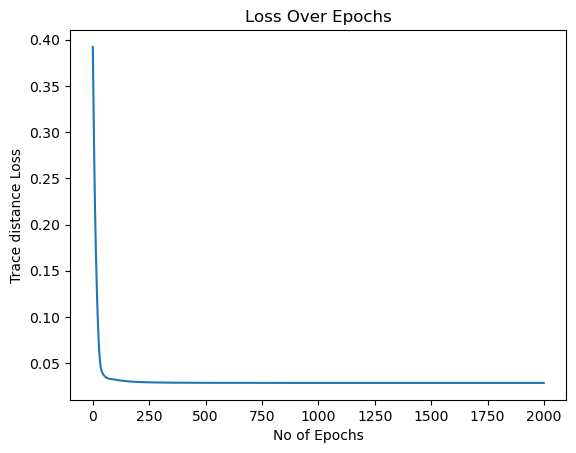

In [17]:
plt.plot(loss_history)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [18]:
min_loss = loss_history[np.argmin(loss_history)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.028596623087155736


In [19]:
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

In [20]:
np.round(reduced_dm,4)

tensor([[0.2500+0.0000j, 0.2012-0.0001j, 0.2012+0.0001j, 0.1524+0.0001j],
        [0.2012+0.0001j, 0.2500+0.0000j, 0.1524+0.0001j, 0.2012-0.0002j],
        [0.2012-0.0001j, 0.1524-0.0001j, 0.2501+0.0000j, 0.2011+0.0001j],
        [0.1524-0.0001j, 0.2012+0.0002j, 0.2011-0.0001j, 0.2500-0.0000j]],
       dtype=torch.complex128)

In [21]:
np.round(target_dm,4)

tensor([[0.3536, 0.2357, 0.2357, 0.1179],
        [0.2357, 0.3536, 0.1179, 0.2357],
        [0.2357, 0.1179, 0.3536, 0.2357],
        [0.1179, 0.2357, 0.2357, 0.3536]])

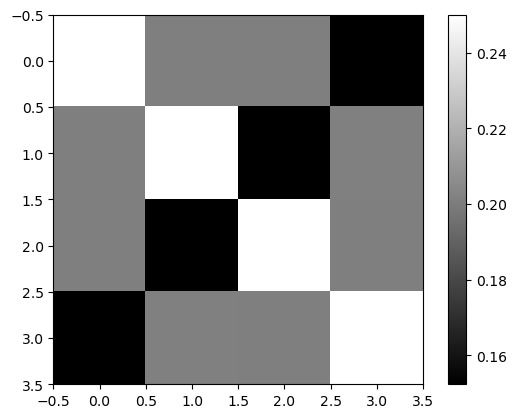

In [22]:
plt.imshow(reduced_dm.real,cmap="grey")
plt.colorbar()

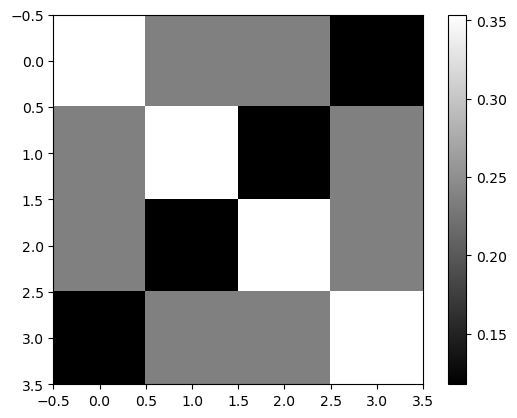

In [23]:
plt.imshow(target_dm.real,cmap="grey")
plt.colorbar()

## Training over the Register Basis

In [24]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[n_qubits+i,n_qubits+i+1])
    qml.IsingXY(ising_params1[-1],wires=[n_qubits+total_qubits-1,n_qubits])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[n_qubits+i,n_qubits+i+1])
    qml.IsingZZ(ising_params2[-1],wires=[n_qubits+total_qubits-1,n_qubits])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,interface="torch")
def reg_circuit(input_params,trained_params=optimal_params,folds=folds,num_qubits=n_ancillas,total_qubits=total_qubits):
    
    for i in range(total_qubits):
        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)

    for i in range(folds):
        vqc_circuit(params=input_params[i],total_qubits=n_ancillas)
    
    output = qml.state()

    return output


In [25]:
reg_params = torch.rand((folds, 3 * n_ancillas), requires_grad=True, dtype=torch.float32)

(<Figure size 5800x600 with 1 Axes>, <Axes: >)

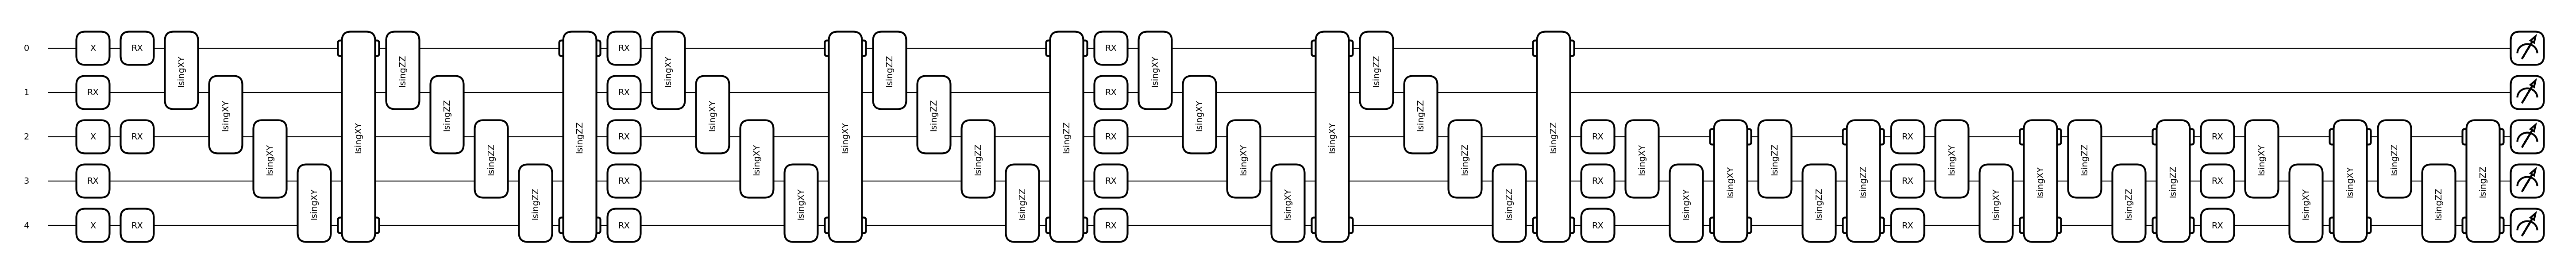

In [26]:
qml.draw_mpl(reg_circuit)(reg_params)

In [ ]:
weights = reg_params
opt = torch.optim.Adam([weights], lr=0.1)

reg_loss_history = []
optimal_reg_params = torch.zeros((folds, 3 * n_ancillas), dtype=torch.float32)
min_loss = vqc(reg_circuit, weights, target_full_dm)
n_epochs = 1000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss_val = vqc(reg_circuit, weights, target_full_dm)
    loss_val.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")
    reg_loss_history.append(loss_val)

    if loss_val < min_loss:
        min_loss = loss_val
        optimal_reg_params = weights.detach().clone()


Step: 10 Loss: -0.41494620436448626 Time taken per iter: 0.007688045501708984
Step: 20 Loss: -0.5614784843070948 Time taken per iter: 0.0076904296875
Step: 30 Loss: -0.6063717829478962 Time taken per iter: 0.00746607780456543
Step: 40 Loss: -0.6329690625837064 Time taken per iter: 0.007947206497192383
Step: 50 Loss: -0.6461803616423816 Time taken per iter: 0.007302045822143555
Step: 60 Loss: -0.6495865880279493 Time taken per iter: 0.0074727535247802734
Step: 70 Loss: -0.6513225007799044 Time taken per iter: 0.007853984832763672
Step: 80 Loss: -0.6520742901302079 Time taken per iter: 0.00743412971496582
Step: 90 Loss: -0.6521789087843755 Time taken per iter: 0.007482290267944336
Step: 100 Loss: -0.6523216855690858 Time taken per iter: 0.0074939727783203125
Step: 110 Loss: -0.6523763906434833 Time taken per iter: 0.007405281066894531
Step: 120 Loss: -0.65243817324651 Time taken per iter: 0.007364034652709961
Step: 130 Loss: -0.6524915172205251 Time taken per iter: 0.007518768310546875
S

In [28]:
full_psi = reg_circuit(optimal_reg_params)

In [29]:
obtained_dm = reduce_statevector(full_psi, indices=range(n_qubits))
obtained_dm = obtained_dm / torch.linalg.norm(obtained_dm)

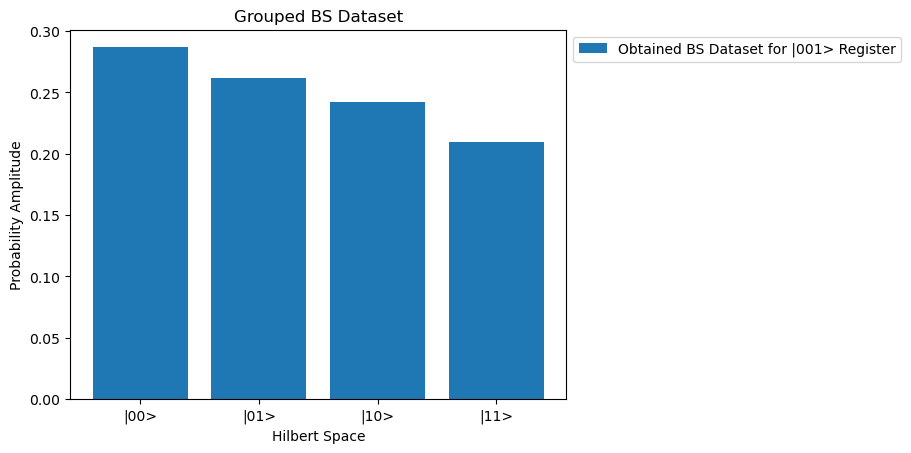

In [66]:
image = qnp.round(full_psi[5::8],3)
image /= qnp.linalg.norm(image)

x = ["|00>", "|01>", "|10>", "|11>"]

# plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x, np.abs(image)**2, label='Obtained BS Dataset for |001> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [45]:
data

tensor([[0., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 0., 0.],
        [0., 0., 1., 1.],
        [1., 1., 1., 1.]])

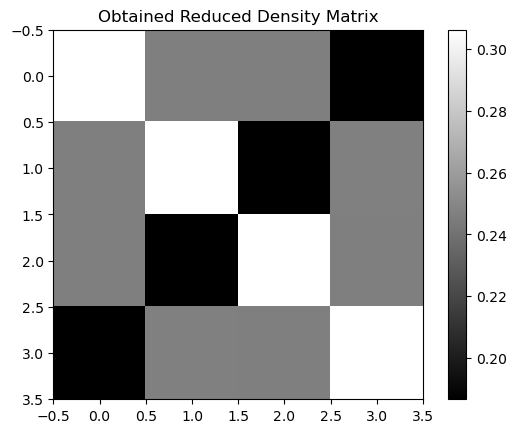

In [31]:
plt.imshow(obtained_dm.real, cmap="gray")
plt.colorbar()
plt.title("Obtained Reduced Density Matrix")
plt.show()

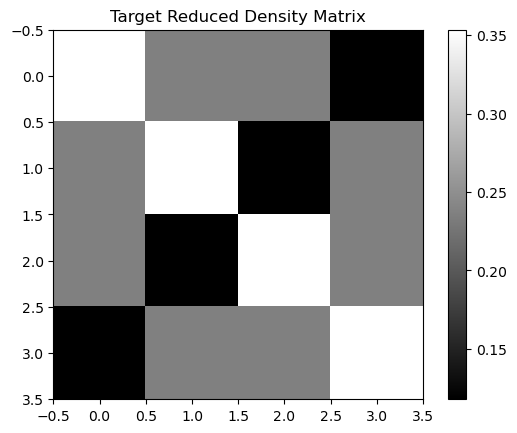

In [32]:
plt.imshow(target_dm.real, cmap="gray")
plt.colorbar()
plt.title("Target Reduced Density Matrix")
plt.show()

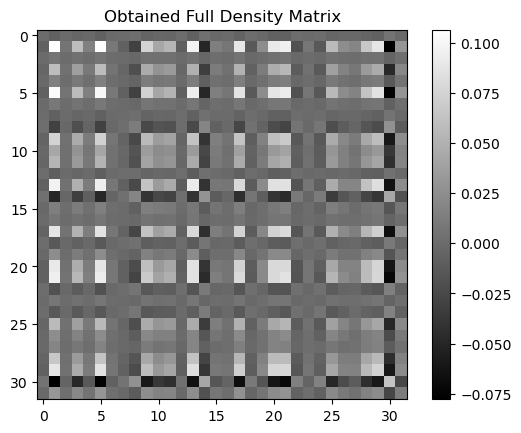

In [33]:
plt.imshow(qml.math.dm_from_state_vector(full_psi).real, cmap="grey")
plt.colorbar()
plt.title("Obtained Full Density Matrix")
plt.show()

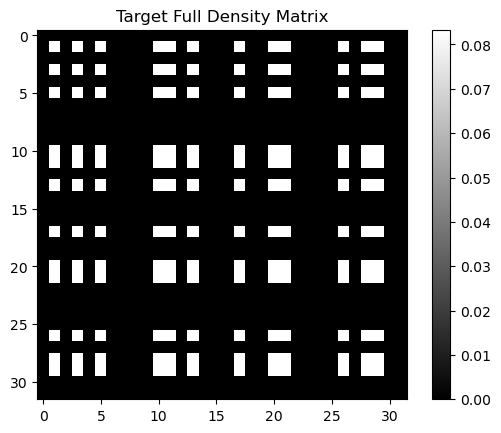

In [34]:
plt.imshow(target_full_dm.real, cmap="grey")
plt.colorbar()
plt.title("Target Full Density Matrix")
plt.show()